In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from tensorflow.keras import backend as K
from random import getrandbits
import math
from IPython.display import clear_output
import cv2

## Dataset 

In [2]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if (os.path.isdir(os.path.join(dir, d)))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

AUDIO_EXTENSIONS = ['.wav', '.WAV']

def is_audio_file(filename):
    return any(filename.endswith(extension) for extension in AUDIO_EXTENSIONS)

In [3]:
def random_onoff():                # randomly turns on or off
    return bool(getrandbits(1))


def augment_signal(y, sr, quiet=True):
    count_changes = 0
    allow_pitch, allow_dyn, allow_noise = True, True, True
    y_mod = y
    # change pitch (w/o speed)
    if (allow_pitch) and random_onoff():
        bins_per_octave = 24  # pitch increments are quarter-steps
        pitch_pm = 4  # +/- this many quarter steps
        pitch_change = pitch_pm * 2 * (np.random.uniform() - 0.5)
        if not quiet:
            print("    pitch_change = ", pitch_change)
        y_mod = librosa.effects.pitch_shift(y, sr, n_steps=pitch_change, bins_per_octave=bins_per_octave)
        count_changes += 1
    # change dynamic range
    if (allow_dyn) and random_onoff():
        dyn_change = np.random.uniform(low=0.5, high=1.1)  # change amplitude
        if not quiet:
            print("    dyn_change = ", dyn_change)
        y_mod = y_mod * dyn_change
        count_changes += 1
        # add noise
    if (allow_noise) and random_onoff():
        noise_amp = 0.005 * np.random.uniform() * np.amax(y)
        if random_onoff():
            if not quiet:
                print("    gaussian noise_amp = ", noise_amp)
            y_mod += noise_amp * np.random.normal(size=len(y))
        else:
            if not quiet:
                print("    uniform noise_amp = ", noise_amp)
            y_mod += noise_amp * np.random.uniform(size=len(y))
        count_changes += 1

    # last-ditch effort to make sure we made a change (recursive/sloppy, but...works)
    if (0 == count_changes):
        if not quiet:
            print("No changes made to signal, trying again")
        y_mod = augment_signal(y_mod, sr, quiet=quiet)

    return y_mod


def spect_loader(path, window_size=.02, window_stride=.01, window='hamming', normalize=True, max_len=101, augment=False):
    y, sr = sf.read(path)
    y_original_len = len(y)
    
    if augment:
        y = augment_signal(y, sr)
    if not len(y) == y_original_len:
        print('augmentation ruined the audio files length!!!')
        exit()
    
    try:
        n_fft = int(sr * window_size)
    except:
        print(path)

    win_length = n_fft
    hop_length = int(sr * window_stride)
    
    # STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
    
    spect, phase = librosa.magphase(D)
    spect = np.log1p(spect)
    real_features_len = spect.shape[1]
    
    # make all spects with the same dims
    if spect.shape[1] < max_len:
        pad = np.zeros((spect.shape[0], max_len - spect.shape[1]))
        spect = np.hstack((spect, pad))
    elif spect.shape[1] > max_len:
        spect = spect[:, :max_len]

    if spect.shape[0] < 160:
        pad = np.zeros((160 - spect.shape[0], spect.shape[1]))
        spect = np.vstack((spect, pad))
    elif spect.shape[0] > 160:
        spect = spect[:160, :]
    spect = np.resize(spect, (spect.shape[0], spect.shape[1], 1))
    #spect = torch.FloatTensor(spect) 
    
    #normalization to zero-mean and one-std
    normalize = True
    if normalize:
        mean = np.mean(spect)
        std = np.std(spect)
        if std != 0:
            spect = spect - mean
            spect = spect / std
            
    return spect, len(y), real_features_len, sr

In [4]:
# This is the original data loader

def SpeechYOLO_dataloader(root_dir, configs, augment=False):
    
    C = configs["C"]
    B = configs["B"]
    k = configs["K"]
    classes, class_to_idx = find_classes(root_dir)

    spects = []
    count = 0
    dir = os.path.expanduser(root_dir)

    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                count += 1
                if is_audio_file(fname):
                    path = os.path.join(root, fname)
                    x = os.path.getsize(path)
                    if x < 1000:
                        print (path)
                        continue
                    label = os.path.join(root, fname.replace(".wav", ".wrd"))
                    tclass = class_to_idx[target]
                    item = (path, label, tclass)
                    spects.append(item) 

    data = spects

    y_true = np.zeros([len(data), C, (B*3 + k +1)], dtype=np.float64)
    x_features = np.zeros([len(data), 224, 224, 3], dtype=np.float64)

    for idx in range(len(data)):

        features_path = data[idx][0]
        add_augment = False
        add_augment = random_onoff()
        features, dot_len, real_features_len, sr = spect_loader(features_path)
        target_path = data[idx][1]
        target = open(target_path, "r").readlines()
    
        features = np.reshape(cv2.resize(features, dsize=(224,224), interpolation=cv2.INTER_NEAREST),(224,224,1))
        num_features, features_wav_len, _ = np.shape(features)
        x_features[idx,:,:,:] = np.concatenate((features,features,features), axis=2)
        #x_features = np.concatenate((x_features,x_features,x_features), axis=3)

        divide = sr/features_wav_len  # 16000/224 = 71.43, each feature in x contains 158.41 samples from the original wav file
        width_cell = 1.0 * features_wav_len / C  # width per cell  224/6 = 37.33
        line_yolo_data = []  # index, relative x, w, class

        for line_str in target:
            line = line_str.replace("\t", "_").split(" ")
            feature_start = math.floor(float(line[0])/divide)
            feature_end = math.floor(float(line[1])/divide)
            object_width = (feature_end - feature_start)
            center_x = feature_start + object_width / 2.0

            cell_index = int(center_x / width_cell)  # rescale the center x to cell size
            object_norm_x = float(center_x) / width_cell - int(center_x / width_cell)

            object_norm_w = object_width/features_wav_len

            class_label = line[2]
            object_class = class_to_idx[class_label]
            line_yolo_data.append([cell_index, object_norm_x, object_norm_w, object_class])

        #print(line_yolo_data)

        kwspotting_target = np.ones([k]) * (-1)

        for yolo_item in line_yolo_data:
            index = yolo_item[0]
            x = yolo_item[1]
            w = math.sqrt(yolo_item[2])
            obj_class = yolo_item[3]
            y_true[idx, index, B*3 + obj_class] = 1
            y_true[idx, index, -1] = 1


            for box in range(0, B):
                y_true[idx, index, box * 3 + 2] = 1  # IOU
                y_true[idx, index, box * 3] = x  # x
                y_true[idx, index, box * 3 + 1] = w  # w
            kwspotting_target[obj_class] = 1
    
    return x_features, y_true

In [5]:
# This is the batchwise loader

def data_list(root_dir):
    classes, class_to_idx = find_classes(root_dir)

    spects = []
    count = 0
    dir = os.path.expanduser(root_dir)

    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                count += 1
                if is_audio_file(fname):
                    path = os.path.join(root, fname)
                    x = os.path.getsize(path)
                    if x < 1000:
                        print(path)
                        print('bad')
                        continue
                    label = os.path.join(root, fname.replace(".wav", ".wrd"))
                    tclass = class_to_idx[target]
                    item = (path, label, tclass)
                    spects.append(item)
    return spects, class_to_idx

class LocalizationDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, configs, batch_size=32, dim=(224,224), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.data = data[0]
        self.class_to_idx = data[1]
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.configs = configs
        
        self.loader = spect_loader
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        data_temp = [self.data[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(data_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, data_temp):
        
        C = self.configs["C"]
        B = self.configs["B"]
        k = self.configs["K"]

        y_true = np.zeros([len(data_temp), C, (B*3 + k +1)], dtype=np.float64)
        x_features = np.zeros([len(data_temp), 224, 224, 3], dtype=np.float64)

        for idx in range(len(data_temp)):

            features_path = data_temp[idx][0]
            add_augment = False
            add_augment = random_onoff()
            features, dot_len, real_features_len, sr = spect_loader(features_path)
            target_path = data_temp[idx][1]
            target = open(target_path, "r").readlines()

            features = np.reshape(cv2.resize(features, dsize=(224,224), interpolation=cv2.INTER_NEAREST),(224,224,1))
            num_features, features_wav_len, _ = np.shape(features)
            x_features[idx,:,:,:] = np.concatenate((features,features,features), axis=2)

            divide = sr/features_wav_len  # 16000/224 = 71.43, each feature in x contains 158.41 samples from the original wav file
            width_cell = 1.0 * features_wav_len / C  # width per cell  224/6 = 37.33
            line_yolo_data = []  # index, relative x, w, class

            for line_str in target:
                line = line_str.replace("\t", "_").split(" ")
                feature_start = math.floor(float(line[0])/divide)
                feature_end = math.floor(float(line[1])/divide)
                object_width = (feature_end - feature_start)
                center_x = feature_start + object_width / 2.0

                cell_index = int(center_x / width_cell)  # rescale the center x to cell size
                object_norm_x = float(center_x) / width_cell - int(center_x / width_cell)

                object_norm_w = object_width/features_wav_len

                class_label = line[2]
                object_class = self.class_to_idx[class_label]
                line_yolo_data.append([cell_index, object_norm_x, object_norm_w, object_class])

            #print(line_yolo_data)

            kwspotting_target = np.ones([k]) * (-1)

            for yolo_item in line_yolo_data:
                idx2 = yolo_item[0]
                x = yolo_item[1]
                w = math.sqrt(yolo_item[2])
                obj_class = yolo_item[3]
                y_true[idx, idx2, B*3 + obj_class] = 1
                y_true[idx, idx2, -1] = 1


                for box in range(0, B):
                    y_true[idx, idx2, box * 3 + 2] = 1  # IOU
                    y_true[idx, idx2, box * 3] = x  # x
                    y_true[idx, idx2, box * 3 + 1] = w  # w
                kwspotting_target[obj_class] = 1

        return x_features, y_true

## Model

In [6]:
#PretrainedModel = tf.keras.models.load_model("Pretrain_gcommand_20epochs_224x224x3.h5")
PretrainedModel = tf.keras.models.load_model("Pretrain_gcommand_20epochs_MobileNetV2.h5")
clear_output()

In [7]:
PretrainedModel.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1881630   
Total params: 4,139,614
Trainable params: 4,105,502
Non-trainable params: 34,112
_________________________________________________________________


In [8]:
def SpeechYOLO(PretrainedModel, c, b, k):
    
    inputs = tf.keras.Input(shape=(224,224,3))
    #base_model = tf.keras.Model(inputs=PretrainedModel.input, outputs=PretrainedModel.get_layer('dense').output) #VGG19 backbone
    base_model = tf.keras.Model(inputs=PretrainedModel.input, outputs=PretrainedModel.get_layer('flatten_2').output) #MobileNetV2
    #print(base_model.summary())
    #base_model.trainable = False

    x = base_model(inputs)

    branch01 = tf.keras.layers.Dense(c*b)(x)
    branch02 = tf.keras.layers.Dense(c*b)(x)
    branch03 = tf.keras.layers.Dense(c*b)(x)
    branch04 = tf.keras.layers.Dense(c*k)(x)
    branch11 = tf.keras.layers.Reshape((c,b))(branch01)
    branch12 = tf.keras.layers.Reshape((c,b))(branch02)
    branch13 = tf.keras.layers.Reshape((c,b))(branch03)
    branch14 = tf.keras.layers.Reshape((c,k))(branch04)

    branch21 = tf.keras.activations.sigmoid(branch11)
    branch22 = tf.keras.activations.sigmoid(branch12)
    branch23 = tf.keras.activations.sigmoid(branch13)
    branch24 = tf.keras.activations.softmax(branch14)

    outputs = tf.keras.layers.concatenate([branch21, branch22, branch23, branch24], 2)

    newModel = tf.keras.Model(inputs, outputs=outputs)
    
    return newModel

## Loss 

In [9]:
def YOLOloss():
    
    def loss(y_true, y_pred):
    
        C=6
        B=2
        k=10
        noobject_conf=0.5
        obj_conf=1
        coordinate=10
        class_conf=1

        y_pred = tf.cast(y_pred, dtype='float64')
        y_true = tf.cast(y_true, dtype='float64')

        # targets
        target_coords = K.reshape(y_true[:, :, :3 * B], (-1, C, B, 3))  # get all the x,w values for all the boxes
        target_xs = K.reshape(target_coords[:, :, :, 0], (-1, C, B, 1))
        target_xs_no_norm = K.reshape(target_coords[:, :, :, 0], (-1, C, B, 1)) / float(C)
        target_ws = K.pow(K.reshape(target_coords[:, :, :, 1], (-1, C, B, 1)), 2)  # assuming the prediction is for sqrt(w)
        target_conf = K.reshape(target_coords[:, :, :, 2], (-1, C, B, 1))
        target_start = target_xs_no_norm - (target_ws * 0.5)
        target_end = target_xs_no_norm + (target_ws * 0.5)
        target_class_prob = K.reshape(y_true[:, :, 3 * B:-1], (-1, C, k, 1))

        # pred
        pred_coords = K.reshape(y_pred[:, :, :3 * B], (-1, C, B, 3))  # get all the x,w values for all the boxes
        pred_xs = K.reshape(pred_coords[:, :, :, 0], (-1, C, B, 1))
        pred_xs_no_norm = K.reshape(pred_coords[:, :, :, 0], (-1, C, B, 1)) / float(C)
        pred_ws = K.pow(K.reshape(pred_coords[:, :, :, 1], (-1, C, B, 1)), 2)  # assuming the prediction is for sqrt(w)
        pred_conf = K.reshape(pred_coords[:, :, :, 2], (-1, C, B, 1))
        pred_start = pred_xs_no_norm - (pred_ws * 0.5)
        pred_end = pred_xs_no_norm + (pred_ws * 0.5)
        pred_class_prob = K.reshape(y_pred[:, :, 3 * B:], (-1, C, k, 1))

        # Calculate the intersection areas
        intersect_start = K.maximum(pred_start, target_start)
        intersect_end = K.minimum(pred_end, target_end)
        intersect_w = intersect_end - intersect_start

        # Calculate the best IOU, set 0.0 confidence for worse boxes
        iou = intersect_w / (pred_ws + target_ws - intersect_w)
        iou_max_value = K.max(iou,2)
        iou_max_indices = K.argmax(iou,2)

        best_box = tf.cast(tf.equal(iou, tf.expand_dims(iou_max_value,2)), dtype='float64')
        one_confs_per_cell = best_box * target_conf

        real_exist = tf.reshape(y_true[:,:,-1], tf.shape(iou_max_indices))
        obj_exists_classes = tf.reshape(tf.tile(tf.expand_dims(real_exist,2),[1,1,k,1]),(-1, C, k, 1)) #tf.reshape(tf.repeat(real_exist, k, 2), (-1, C, k, 1))
        obj_exists = one_confs_per_cell
        noobj_exists = tf.zeros([tf.shape(obj_exists)[0], C, B, 1], dtype='float64')
        noobj_exists = tf.cast(tf.equal(one_confs_per_cell, noobj_exists),dtype='float64')

        first_part = K.sum(flatten(coordinate * obj_exists * K.pow((pred_xs - target_xs),2)), 1)
        second_part = K.sum(flatten(coordinate * obj_exists * K.pow((pred_ws - target_ws), 2)), 1)

        third_part = K.sum(flatten(obj_conf * obj_exists * K.pow((pred_conf - one_confs_per_cell), 2)), 1)
        fourth_part = K.sum(flatten(noobject_conf * noobj_exists * K.pow((pred_conf - one_confs_per_cell), 2)), 1)
        fifth_part = K.sum(flatten(class_conf * obj_exists_classes * K.pow((target_class_prob - pred_class_prob), 2)), 1)

        total_loss = first_part + second_part + third_part + fourth_part + fifth_part

        total_loss = tf.cast(total_loss, dtype='float32')

        return K.mean(total_loss)
    
    return loss

def flatten(x):
    return tf.reshape(x, [tf.shape(x)[0],-1])


## Metrics 

In [10]:
def calc_iou(pred, target):

    pred_start, pred_end = pred[0], pred[1]
    target_start, target_end = target[0], target[1]

    intersect_start = max(pred_start, target_start)
    intersect_end = min(pred_end, target_end)
    intersect_w = intersect_end - intersect_start

    if intersect_w < 0:  # no intersection
        intersect_w = 0.0

    pred_len = pred_end - pred_start
    target_len = target_end - target_start

    union = pred_len + target_len - intersect_w
    iou = float(intersect_w) / union
    return iou


def extract_data(out_tesor, C, B, K):

    out_coords = tf.reshape(out_tesor[:, :, :3 * B], (-1, C, B, 3))
    out_xs = tf.reshape(out_coords[:, :, :, 0], (-1, C, B)) / float(C)
    out_ws = tf.pow(tf.reshape(out_coords[:, :, :, 1], (-1, C, B)), 2)
    out_start = (out_xs - (out_ws * 0.5))
    out_end = (out_xs + (out_ws * 0.5))
    pred_class_prob = tf.reshape(out_tesor[:, :, 3 * B:], (-1, C, K))
    pred_class_prob = tf.reshape(tf.tile(tf.expand_dims(pred_class_prob,2),[1,1,B,1]), (-1, C, B, K))
    pred_conf = tf.reshape(out_coords[:, :, :, 2], (-1, C, B))
    #with tf.Session() as sess:
    #    out_ws = out_ws.eval()
    #    out_start = out_start.eval()
    #    out_end = out_end.eval()
    #    pred_conf = pred_conf.eval()
    #    pred_class_prob = pred_class_prob.eval()
    return out_ws, out_start, out_end, pred_conf, pred_class_prob

In [11]:
def YOLO_accuracy(y_true, y_pred, C=6, B=2, k=10, T=0.25, iou_t=0.5):

    correct_class_high_iou = 0
    correct_class_low_iou = 0
    wrong_class_high_iou = 0
    wrong_class_low_iou = 0
    total_correct_class = 0

    pred_ws, pred_start, pred_end, pred_conf, pred_class_all_prob = extract_data(y_pred, C, B, k)

    pred_classes_prob = K.max(pred_class_all_prob, 3)
    pred_classes = K.argmax(pred_class_all_prob, 3)
    conf_class_mult = K.max((pred_conf* pred_classes_prob), 2)
    box_index = K.argmax((pred_conf* pred_classes_prob), 2)

    no_object_correct = K.sum(tf.cast(tf.equal(tf.cast((conf_class_mult<T),dtype='float64'), 1 - y_true[:, :, -1]), dtype='float64'))
    no_object_object_wrong = K.sum(tf.cast(tf.equal(tf.cast((conf_class_mult<T),dtype='float64'), y_true[:, :, -1]), dtype='float64'))

    target_ws, target_start, target_end, target_conf, target_class_all_prob = extract_data(y_true[:, :, :-1], C, B, k)
    target_classes_prob = K.max(target_class_all_prob, 3)
    target_classes = K.argmax(target_class_all_prob, 3)

    with tf.Session() as sess:
        size_temp = tf.shape(target_start)[0].eval()
        box_indices_array = box_index.eval()
        target_start = target_start.eval()
        pred_start = pred_start.eval()
        target_end = target_end.eval()
        pred_end = pred_end.eval()
        target_ws = target_ws.eval()
        pred_ws = pred_ws.eval()

    #print(pred_ws)


    squeeze_target_start = np.zeros([size_temp, C])
    squeeze_pred_start = np.zeros([size_temp, C])
    squeeze_target_end = np.zeros([size_temp, C])
    squeeze_pred_end = np.zeros([size_temp, C])
    squeeze_target_ws = np.zeros([size_temp, C])
    squeeze_pred_ws = np.zeros([size_temp, C])

    #print(type(box_indices_array.shape[0]))    

    for row in range(0, box_indices_array.shape[0]):
        for col in range(0, box_indices_array.shape[1]):
            squeeze_target_start[row, col] = target_start[row, col, box_indices_array[row, col]]
            squeeze_pred_start[row, col] = pred_start[row, col, box_indices_array[row, col]]
            squeeze_target_end[row, col] = target_end[row, col, box_indices_array[row, col]]
            squeeze_pred_end[row, col] = pred_end[row, col, box_indices_array[row, col]]
            squeeze_target_ws[row, col] = target_ws[row, col, box_indices_array[row, col]]
            squeeze_pred_ws[row, col] = pred_ws[row, col, box_indices_array[row, col]]

    squeeze_target_start = tf.convert_to_tensor(squeeze_target_start)
    squeeze_pred_start = tf.convert_to_tensor(squeeze_pred_start)
    squeeze_target_end = tf.convert_to_tensor(squeeze_target_end)
    squeeze_pred_end = tf.convert_to_tensor(squeeze_pred_end)
    squeeze_target_ws = tf.convert_to_tensor(squeeze_target_ws)
    squeeze_pred_ws = tf.convert_to_tensor(squeeze_pred_ws)

    intersect_start = K.maximum(squeeze_pred_start, squeeze_target_start)
    intersect_end = K.minimum(squeeze_pred_end, squeeze_target_end)
    intersect_w = intersect_end - intersect_start

    iou_mask = tf.cast(tf.equal(tf.cast(tf.equal(tf.cast(conf_class_mult > T, dtype='float64'), y_true[:, :, -1]), dtype='float64'), y_true[:, :, -1]), dtype='float64')
    iou = intersect_w / (squeeze_pred_ws + squeeze_target_ws - intersect_w)
    iou_select = iou * iou_mask

    mean_iou_correct = 0.0
    mean_iou_wrong = 0.0

    with tf.Session() as sess:
        is_object = y_true[:, :, -1].eval()
        conf_class_mult = conf_class_mult.eval()
        iou_select = iou_select.eval()

    for batch in range(0, box_indices_array.shape[0]):
        for cell in range(0, box_indices_array.shape[1]):
            if is_object[batch, cell] != 1 or (conf_class_mult > T)[batch,cell] != 1:
                print(is_object[batch, cell])
                print((conf_class_mult > T)[batch,cell])
                print('do nothing')
                continue
            if pred_classes[batch, cell, 0] != target_classes[batch, cell, 0]:  # predict object with wrong class
                print('predict object with wrong class')
                if iou_select[batch, cell] < iou_t:
                    wrong_class_low_iou += 1
                else:
                    wrong_class_high_iou += 1

                mean_iou_wrong += iou_select[batch, cell]
            else:  # predict object with right class
                print('predict object with right class')
                if iou_select[batch, cell] < iou_t:
                    correct_class_low_iou += 1
                else:
                    correct_class_high_iou += 1
                mean_iou_correct += iou_select[batch, cell]

            total_correct_class += 1

    return total_correct_class, mean_iou_wrong, mean_iou_correct

In [12]:
def convert_yolo_tags(pred, c, b, k, threshold):
    GAP_THRESH = 0.01 #MINIMUM GAP TO SEPARATE TWO IDENTICLE WORDS
    pred_ws, pred_start, pred_end, pred_conf, pred_class_prob = extract_data(pred, c, b, k)

    with tf.Session() as sess:
        pred_ws = pred_ws.eval()
        pred_start = pred_start.eval()
        pred_end = pred_end.eval()
        pred_conf = pred_conf.eval()
        pred_class_prob = pred_class_prob.eval()

    class_max = np.max(pred_class_prob, 3)
    class_indices = np.argmax(pred_class_prob, 3)
    conf_max = np.max((pred_conf * class_max), 2)
    box_indices = np.argmax((pred_conf * class_max), 2)
    selected_box_index=0

    pass_conf = (conf_max >= threshold)
    labels = []
    for batch in range(0, np.shape(pred)[0]):
        for cell_i in range(0, np.shape(pred)[1]):
            if (pass_conf[batch, cell_i] > 0):
                selected_box_index = box_indices[batch, cell_i]
                selected_class_index = class_indices[batch, cell_i, 0]
                label_start = pred_start[batch, cell_i, selected_box_index]
                label_end = pred_end[batch, cell_i, selected_box_index]
                w = pred_ws[batch, cell_i, selected_box_index]
                x = (label_end + label_start)/2
                labels.append([cell_i, x, w, selected_class_index, batch])

    width_cell = 1. / c  # width per cell
    final_pred_labels = {}

    for label in labels:
        real_x = (label[0] * width_cell + label[1])  # label[1] was already multiple with width cell
        real_w = label[2]
        cur_start = (real_x - float(real_w) / 2.0)
        cur_end = (real_x + float(real_w) / 2.0)
        cur_class = str(label[4])+ "_" + str(label[3]) # batch_class

        if cur_class not in final_pred_labels:
            final_pred_labels[cur_class] = []

        else:
            prev_start = final_pred_labels[cur_class][-1][0]
            prev_end = final_pred_labels[cur_class][-1][1]
            if cur_start >= prev_end and cur_end >= prev_start:
                # --------
                #          -------
                if cur_end - prev_end <= GAP_THRESH:
                    final_pred_labels[cur_class].pop() #remove last item
                    cur_start = prev_start
            elif cur_start <= prev_end and prev_end <= cur_end:
                # --------
                #      -------
                final_pred_labels[cur_class].pop() #remove last item
                cur_start = prev_start
            elif cur_start >= prev_start and cur_end <= prev_end:
                # -----------
                #    ----
                final_pred_labels[cur_class].pop() #remove last item
                cur_start = prev_start
                cur_end = prev_end
            elif cur_start <= prev_start and cur_end >= prev_end:
                #     -----
                #   ---------
                final_pred_labels[cur_class].pop() #remove last item

        final_pred_labels[cur_class].append([cur_start, cur_end])
    return final_pred_labels

In [13]:
def counter_for_actual_accuracy(pred_labels, target_labels):
    iou_choice_counter = 0
    mega_iou_choice = []
    for key, pred_label_list in pred_labels.items():
        if key in target_labels:
            iou_list = []
            target_label_list = target_labels[key]
            for target_idx, target_label in enumerate(target_label_list):
                for pred_idx, pred_label in enumerate(pred_label_list):
                    iou_val = calc_iou(pred_label, target_label)
                    iou_list.append([iou_val, pred_idx, target_idx, pred_label, target_label])

            list_len = min(len(target_label_list), len(pred_label_list))
            iou_list = sorted(iou_list, key=lambda k: (k[0], np.random.random()), reverse = True) 
            iou_choice = []
            while len(iou_list) != 0 and len(iou_choice) < list_len:
                if len(iou_choice) == 0:
                    iou_choice.append(iou_list.pop(0))
                else:
                    #pdb.set_trace()
                    cur_item = iou_list.pop(0)
                    flag = True
                    for item in iou_choice:
                        if cur_item[1] == item[1]:
                            flag = False
                            break
                        if cur_item[2] == item[2]:
                            flag = False
                            break
                    if flag:
                        iou_choice.append(cur_item)

            mega_iou_choice.extend(iou_choice)

    #============================================================================================

    #for actual accuracy: check if center of prediction is within (start, end) boundaries of target
    for item in mega_iou_choice:
        iou_val, pred_idx, target_idx, pred_label, target_label = item
        pred_start, pred_end = pred_label
        target_start, target_end = target_label

        center_pred = float(pred_end + pred_start) / 2

        if round(center_pred,2) >= round(target_start,2) and round(center_pred,2) <= round(target_end,2):
            iou_choice_counter += 1

    return iou_choice_counter

In [14]:
def eval_actual(output, target, threshold, c, b, k):
    
    actual_lens = np.zeros(2) # num_position_correct, len(target_labels

    #pred = output
    pred = target[:,:,:-1]

    pred_labels = convert_yolo_tags(output, c, b, k, threshold)
    target_labels = convert_yolo_tags(target[:,:,:-1], c, b, k, threshold)

    num_position_correct = counter_for_actual_accuracy(pred_labels, target_labels)

    num_classes = k
    acc_per_term = np.zeros((num_classes,3)) #tp, fp, fn
    f1_per_term = np.zeros(num_classes)

    for pred_key, pred_list in pred_labels.items(): # dict of keys "batch_wordIdx"
        pred_word = int(pred_key.split('_')[1])

        if pred_key in target_labels:

            target_list = target_labels[pred_key]
            len_target = len(target_list)
            len_pred = len(pred_list)
            if len_target == len_pred:
                acc_per_term[pred_word][0] += len_target #true positive
            if len_target < len_pred:
                acc_per_term[pred_word][1] += len_pred - len_target #false positive
                acc_per_term[pred_word][0] += len_target #true positive
            if len_target > len_pred:
                #not calculating "miss" here
                acc_per_term[pred_word][0] += len_pred

        else:
            acc_per_term[pred_word][1] +=1 #false positive

    count_existance = np.zeros(k)
    exists_counter = 0
    for target_key, target_list in target_labels.items():
        target_word = int(target_key.split('_')[1])
        count_existance[target_word] += len(target_list)
        exists_counter += len(target_list)

    for item in range(len(acc_per_term)): #false negative == miss
        acc_per_term[item][2] = count_existance[item] - acc_per_term[item][0] 

    actual_lens[0], actual_lens[1] = num_position_correct, exists_counter

    return acc_per_term, actual_lens

In [15]:
def evaluation_measures(output, target):
    c=6
    b=2
    k=10
    threshold = args.iou_threshold
    num_classes = k
    
    total_acc_per_term = np.zeros((num_classes, 3)) #np.zeros((NUM_CLASSES,3)) #tp, fp, fn
    total_actual_lens = np.zeros(2)
    acc_per_term, actual_lens = eval_actual(output, target,  threshold, c, b, k)
    total_acc_per_term += acc_per_term
    total_actual_lens += actual_lens
    
    f1_per_term = np.zeros(num_classes)
    precision = 0
    #calculate F1 score for each class
    for item in range(len(total_acc_per_term)):
        if total_acc_per_term[item][0] + total_acc_per_term[item][1] + total_acc_per_term[item][2] == 0:
            continue #zeros
        f1_per_term[item] = (2*total_acc_per_term[item][0]) / (2*total_acc_per_term[item][0] + total_acc_per_term[item][1] + total_acc_per_term[item][2])

    #precision: TP/(TP + FP)    
    temp_acc_sum = np.sum(total_acc_per_term, 0) #collapsing K dimension
    
    
    if float(temp_acc_sum[0]) == 0: precision = 0
    else:  precision = float(temp_acc_sum[0]) / float(temp_acc_sum[0] + temp_acc_sum[1])
    
    if float(temp_acc_sum[0]) == 0: recall = 0
    else: recall = float(temp_acc_sum[0]) / float(temp_acc_sum[0] + temp_acc_sum[2])

    if float(temp_acc_sum[0]) + float(temp_acc_sum[1]) + float(temp_acc_sum[2]) == 0: f1 = 0
    else: f1 = (2 * float(temp_acc_sum[0]))/ ( 2 * float(temp_acc_sum[0]) + float(temp_acc_sum[1]) + float(temp_acc_sum[2]))
    
    return precision, recall, np.mean(f1)

## Main Training

In [16]:
import argparse
import numpy as np
import os

parser = argparse.ArgumentParser(description='train yolo model')
#parser.add_argument('--train_data', type=str, default='Outputs_100_train',
#                    help='location of the train data')
#parser.add_argument('--val_data', type=str, default='Outputs_100',
#                    help='location of the validation data')

parser.add_argument('--train_data', type=str, default='LibriSpeech/train',
                    help='location of the train data')
parser.add_argument('--val_data', type=str, default='LibriSpeech/validation',
                    help='location of the validation data')

parser.add_argument('--arc', type=str, default='VGG19',
                    help='arch method (LeNet, VGG11, VGG13, VGG16, VGG19)')
parser.add_argument('--opt', type=str, default='adam',
                    help='optimization method: adam || sgd')
parser.add_argument('--momentum', type=float, default='0.9',
                    help='momentum')
parser.add_argument('--c_b_k', type=str, default='6_2_10', help='C B K parameters') #should be 6_2_1000 in the paper
parser.add_argument('--prev_classification_model', type=str, default='gcommand_pretraining_model/optimizer_adam_lr_0.001_batch_size_32_arc_VGG19_class_num_30.pth',
                    help='the location of the prev classification model')
parser.add_argument('--lr', type=float, default=0.001,
                    help='initial learning rate')
parser.add_argument('--epochs', type=int, default=100,
                    help='upper epoch limit')
parser.add_argument('--batch_size', type=int, default=16, metavar='N', help='batch size') # default=32
parser.add_argument('--dropout', type=float,  default=0.0,
                    help='dropout probability value')
parser.add_argument('--seed', type=int, default=1245,
                    help='random seed')
parser.add_argument('--cuda', action='store_true',
                    help='use CUDA')
parser.add_argument('--patience', type=int, default=5, metavar='N',
                    help='how many epochs of no loss improvement should we wait before stop training')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='report interval')
#parser.add_argument('--save_folder', type=str,  default='speechyolo_model',
#                    help='path to save the final model')
#parser.add_argument('--save_file', type=str,  default='',
#                    help='filename to save the final model')
parser.add_argument('--trained_yolo_model', type=str, default='',
                    help='load model already trained by this script')
parser.add_argument('--augment_data', action='store_true', help='add data augmentation')
parser.add_argument('--noobject_conf',type=float, default=0.5,
                    help='noobject conf')
parser.add_argument('--obj_conf',type=float, default=1,
                    help='obj conf')
parser.add_argument('--coordinate',type=float, default=10,
                    help='coordinate')
parser.add_argument('--class_conf',type=float, default=1,
                    help='class_conf')
parser.add_argument('--loss_type',type=str, default="mse",
                    help='loss with abs or with mse (abs, mse)')
parser.add_argument('--decision_threshold',type=float, default=0.25,
                    help=' object exist threshold')
parser.add_argument('--iou_threshold',type=float, default=0.5,
                    help='high iou threshold')

# feature extraction options
parser.add_argument('--max_len', type=int, default=101,
                    help='window size for the stft')
parser.add_argument('--window_size', default=.02,
                    help='window size for the stft')
parser.add_argument('--window_stride', default=.01,
                    help='window stride for the stft')
parser.add_argument('--window_type', default='hamming',
                    help='window type for the stft')
parser.add_argument('--normalize', default=True,
                    help='boolean, wheather or not to normalize the spect')
parser.add_argument('--save_folder', type=str,  default='gcommand_pretraining_model/',
                    help='path to save the final model')
parser.add_argument('--class_num', type=int,  default=30,
                    help='number of classes to classify')

args = parser.parse_args(args=[])
print(args)

Namespace(arc='VGG19', augment_data=False, batch_size=16, c_b_k='6_2_10', class_conf=1, class_num=30, coordinate=10, cuda=False, decision_threshold=0.25, dropout=0.0, epochs=100, iou_threshold=0.5, log_interval=100, loss_type='mse', lr=0.001, max_len=101, momentum=0.9, noobject_conf=0.5, normalize=True, obj_conf=1, opt='adam', patience=5, prev_classification_model='gcommand_pretraining_model/optimizer_adam_lr_0.001_batch_size_32_arc_VGG19_class_num_30.pth', save_folder='gcommand_pretraining_model/', seed=1245, train_data='LibriSpeech/train', trained_yolo_model='', val_data='LibriSpeech/validation', window_size=0.02, window_stride=0.01, window_type='hamming')


In [17]:
config_params = args.c_b_k.split('_')
param_names = ['C', 'B', 'K']  # C - cells, B - number of boxes per cell, K- number of keywords
config_dict = {i: int(j) for i, j in zip(param_names, config_params)}

In [18]:
#data_train, labels_train = SpeechYOLO_dataloader(root_dir=args.train_data, configs=config_dict, augment=args.augment_data)
#data_val, labels_val = SpeechYOLO_dataloader(root_dir=args.val_data, configs=config_dict, augment=args.augment_data)

In [19]:
train_list = data_list(args.train_data)
val_list = data_list(args.val_data)

In [20]:
train_step = int(np.floor(len(train_list[0])/32.0))
val_step = int(np.floor(len(val_list[0])/32.0))
data_train = LocalizationDataGenerator(train_list, batch_size=32, configs=config_dict)
data_val = LocalizationDataGenerator(val_list, batch_size=32, configs=config_dict)

In [21]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, val_data=data_val):
        super().__init__()
        self.validation_data = val_data
        #self.batch_size = batch_size
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data))).round()
        count = 0
        val_targ = np.zeros([np.shape(val_predict)[0], np.shape(val_predict)[1], np.shape(val_predict)[2]+1])
        for i in range(len(self.validation_data)):
            val_targ[count:count+len(self.validation_data[i][1]),:,:] = self.validation_data[i][1]
            count += len(self.validation_data[i][1])
        result = evaluation_measures(val_predict, val_targ)
        _val_f1 = result[2]
        _val_recall = result[1]
        _val_precision = result[0]
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        return

In [22]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=25,
    decay_rate=0.9,
    staircase=True)

In [23]:
clf = SpeechYOLO(PretrainedModel, c=6, b=2, k=10)
clf.compile(loss=YOLOloss(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

metrics = Metrics()
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#clf_train = clf.fit(data_train, labels_train, validation_data=(data_val, labels_val), epochs=20, batch_size=64, shuffle=True, callbacks=[metrics])
#scores = clf.evaluate(data_val, labels_val)
clf_train = clf.fit_generator(generator=data_train, steps_per_epoch=train_step, validation_data=data_val, validation_steps=val_step, epochs=80, use_multiprocessing=False, shuffle=False, callbacks=[metrics])
scores = clf.evaluate_generator(data_val, steps=val_step)

Epoch 1/80
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
13/13 [==============================] - 33s 3s/step - loss: 3.3209 - val_loss: 3.3662
Epoch 2/80
13/13 [==============================] - 10s 807ms/step - loss: 3.0713 - val_loss: 3.1673
Epoch 3/80
13/13 [==============================] - 11s 816ms/step - loss: 2.8377 - val_loss: 3.0113
Epoch 4/80
13/13 [==============================] - 11s 814ms/step - loss: 2.6120 - val_loss: 2.8724
Epoch 5/80
13/13 [==============================] - 11s 809ms/step - loss: 2.3848 - val_loss: 2.7655
Epoch 6/80
13/13 [==============================] - 11s 849ms/step - loss: 2.2099 - val_loss: 2.6256
Epoch 7/80
13/13 [==============================] - 10s 806ms/step - loss: 2.0455 - val_loss: 2.6488
Epoch 8/80
13/13 [==============================] - 11s 817ms/step - loss: 1.8719 - val_loss: 2.5856
Epoch 9/80
13/13 [==============================] - 10s 798ms/step - loss: 1.7137 - val_loss: 2.6124


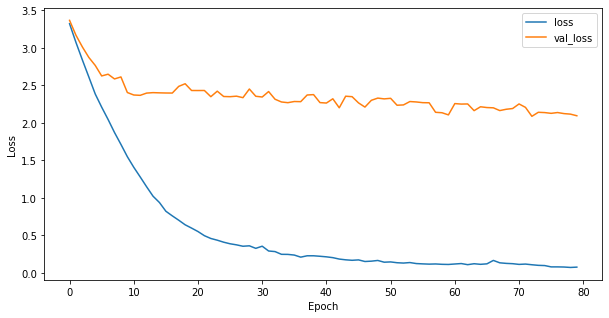

In [24]:
plt.figure(figsize=(10,5))

#Plot loss vs epoch
#### Fill in plot ####
plt.plot(clf_train.history['loss'], label='loss')
plt.plot(clf_train.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#x = range(0,17,2)
#plt.xticks(x)
#plt.ylim([0, 3])
plt.legend(loc='upper right')

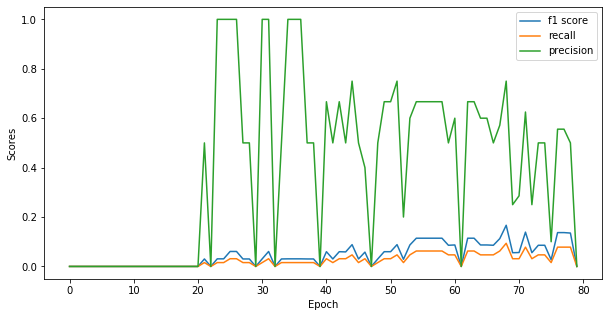

In [25]:
plt.figure(figsize=(10,5))

#Plot loss vs epoch
#### Fill in plot ####
plt.plot(metrics.val_f1s, label='f1 score')
plt.plot(metrics.val_recalls, label = 'recall')
plt.plot(metrics.val_precisions, label = 'precision')
plt.xlabel('Epoch')
plt.ylabel('Scores')
#x = range(0,17,2)
#plt.xticks(x)
#plt.ylim([0, 3])
plt.legend(loc='upper right')

## Testing

In [ ]:
parser = argparse.ArgumentParser(description='test speechYolo model')
parser.add_argument('--train_data', type=str,
                    default='Outputs_100_train',
                    help='location of the train data')
parser.add_argument('--test_data', type=str,
                    default='Outputs_100',
                    help='location of the train data')
parser.add_argument('--model', type=str,
                    default='speechyolo_model/opt_adam_lr_0.001_batch_size_16_arc_VGG19_c_6_b_2_k_10noobject_conf_0.5_obj_conf_1_coordinate_10_class_conf_1_loss_type_mse_.pth',
                    help='the location of the trained speech yolo model')
parser.add_argument('--batch_size', type=int, default=4, metavar='N',
                    help='batch size')
parser.add_argument('--seed', type=int, default=1245,
                    help='random seed')
parser.add_argument('--theta_range', type=str, default='0.1_1.0_0.1', help='0.0_1.0_0.1 format: from 0.0 to 1.0 with step of 0.1')
parser.add_argument('--cuda', action='store_true',
                    help='use CUDA')
parser.add_argument('--iou_threshold', type=float, default=0.5,
                    help='high iou threshold')

args = parser.parse_args(args=[])

#data_test, labels_test = SpeechYOLO_dataloader(root_dir=args.test_data, configs=config_dict)
test_list = data_list(args.test_data)
test_step = int(np.floor(len(test_list)/64.0))
data_test = LocalizationDataGenerator(test_list, batch_size=64, configs=config_dict)

In [ ]:
predictions = clf.predict(data_val)

In [ ]:
output = predictions
target = np.zeros([np.shape(output)[0], np.shape(output)[1], np.shape(output)[2]+1])

count = 0
for i in range(len(data_val)):
    target[count:count+len(data_val[i][1]),:,:] = data_val[i][1]
    count += len(data_val[i][1])

print(target[79,:,:])
print(output[79,:,:])

In [ ]:
#print(output)
#print(target)
output = tf.convert_to_tensor(output)
target = tf.convert_to_tensor(target) 

prediction_result = evaluation_measures(output, target)
f1_score = prediction_result[2]
recall = prediction_result[1]
precision = prediction_result[0]

print('threshold: {}'.format(args.iou_threshold))
print('F1 regular mean: {}'.format(f1_score))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

In [ ]:
res = YOLO_accuracy(target, output)

In [ ]:
print(res)